# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-26jivm6v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-26jivm6v
  Resolved https://github.com/huggingface/transformers to commit e472efb9ac06af641add26c354d2f024c0978395
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 9.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.56.0.dev0-py3-none-any.whl size=12464621 sha256=642aadc0c0a9639c0143f22f49bce3236db20ee7ad35c143b286def181fa22d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lq6ppqly/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
 

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-08-18 19:26:12.315840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755545172.673536      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755545172.777518      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME = "gpt2"
BATCH_SIZE = 8
MAX_SEQ_LENGTH = 512
IMAGE_SIZE = 224

# Data Split Params
VALID_SIZE = 0.10
TEST_SIZE = 0.10
RANDOM_STATE = 42

In [6]:
def clean_text(text):
    if text is None:
        return ""
    # More comprehensive text cleaning for medical reports
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text

def create_data_manifest(xml_dir, img_dir):
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text = clean_text(findings_node.text if findings_node is not None else "")
            
            # Prepend custom section tokens
            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} {tokenizer.eos_token}"

            if not findings_text and not impression_text:
                continue
            
            image_nodes = root.findall(".//parentImage")
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    manifest.append({
                        'image_path': image_path,
                        'report_text': full_report
                    })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [7]:
class IUXRayDataset(Dataset):
    """
    PyTorch Dataset for the IU X-Ray data.
    Processes data on-the-fly.
    """
    def __init__(self, manifest, tokenizer, image_transform):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_path = item['image_path']

        # --- Process Image ---
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        # --- Process Text (WITHOUT PADDING) ---
        tokenized_report = self.tokenizer(
            report_text,
            truncation=True, # Still truncate long reports
            max_length=512   # Use the global max length for truncation
        )

        # The model needs 'labels' for calculating loss.
        # Typically, labels are just a copy of the input_ids.
        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "image": image_tensor,
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels), # Add labels for training
            "image_path":image_path
        }

In [8]:
def custom_collate_fn(batch):
    """
    Custom collate function to dynamically pad the text sequences in a batch.
    """
    # 1. Separate images and text data
    images = [item['image'] for item in batch]
    image_path=[item['image_path'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list = [item['labels'] for item in batch]

    # 2. Stack images into a single tensor
    images = torch.stack(images, dim=0)

    # 3. Pad the text sequences (input_ids and labels)
    # The tokenizer handles padding, creating an attention mask, and converting to tensors.
    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest', # Pad to the longest sequence in this batch
        return_tensors='pt'
    )

    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids'] # We only need the input_ids from the labels padding

    # 4. An important step for loss calculation:
    # Replace the padding token id in labels with -100
    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'image': images,
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels,
        'image_path':image_path
    }

In [9]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token  # Keep this line for consistent padding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:53<00:00, 73.38it/s]



Data successfully split:
Total samples: 7430
Training set:  5944 samples
Validation set: 743 samples
Test set:      743 samples

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'labels', 'image_path'])
Image tensor shape:      torch.Size([8, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 187])
Attention mask shape:    torch.Size([8, 187])
Labels tensor shape:       torch.Size([8, 187])


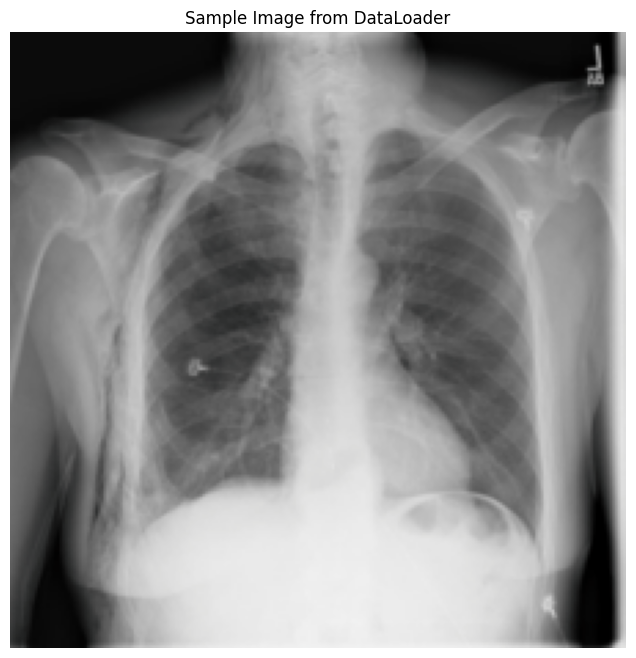


--- Sample Report from the same item (Decoded from Tensors) ---
 the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. there is a thin right apical pneumothorax measuring approximately 5 mm in thickness. there is extensive subcutaneous emphysema in the right chest wall and neck. there are fractures of the right anterior 5th through 9th anterior ribs with mild displacement. additional fractures cannot entirely be excluded. there is mild streaky airspace disease in the right lung base. left lung is clear. there is a small hiatal hernia. there is an intrathecal catheter terminating in the lower thoracic spine.  1. right apical pneumothorax measuring approximately 5 mm in thickness. 2. multiple right-sided rib fractures involving at the right anterior 5th through 9th ribs with mild displacement. 3. mild right basilar airspace disease, atelectasis versus contusion. . 
--------------------------------------------------


In [10]:

image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)


train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)

print(f"\nData successfully split:")
print(f"Total samples: {len(full_manifest)}")
print(f"Training set:  {len(train_manifest)} samples")
print(f"Validation set: {len(val_manifest)} samples")
print(f"Test set:      {len(test_manifest)} samples")

# --- 3. Create Datasets and DataLoaders ---
train_dataset = IUXRayDataset(train_manifest, tokenizer, image_transform)
val_dataset = IUXRayDataset(val_manifest, tokenizer, image_transform)
test_dataset = IUXRayDataset(test_manifest, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,collate_fn=custom_collate_fn)



print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['image'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:       {sample_batch['labels'].shape}") # Added for labels
# Visualize one random item from the batch
# Ensure BATCH_SIZE is defined in your script
idx_to_show = random.randint(0, sample_batch['image'].size(0) - 1)

# --- Decode the report text from input_ids ---
# This is the new way to get the report text for visualization
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

# --- Reverse the normalization for image display ---
img_tensor = sample_batch['image'][idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_display = (img_tensor * std) + mean
img_display = transforms.ToPILImage()(img_display)

# --- Plot the results ---
plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)

# **MambaVision**

In [11]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Stage 4 feature map shape: torch.Size([8, 640, 7, 7])


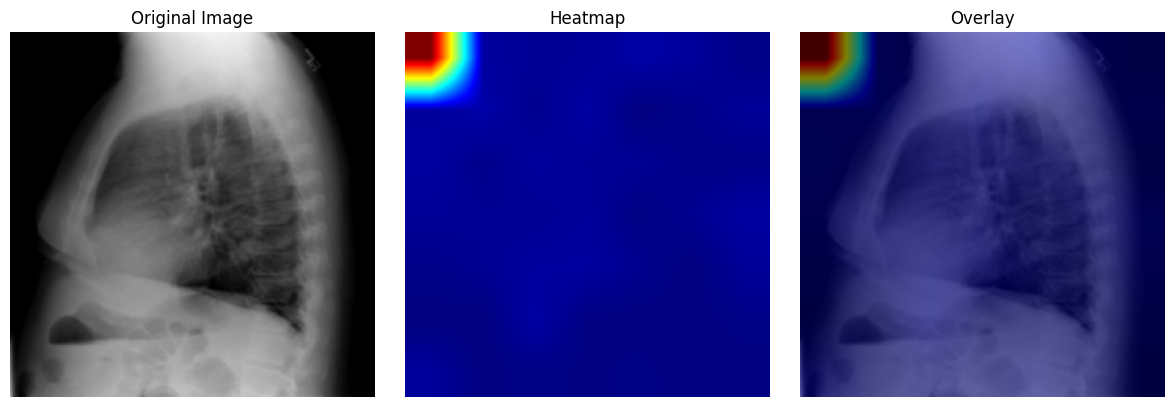

In [12]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)
print(f"Stage 4 feature map shape: {stage_feats[3].shape}")  # (B, 640, 7, 7)

# === Visualize one image with heatmap overlay ===
idx = 0
image_tensor = images[idx].cpu()
feature_map = stage_feats[3][idx]  # (640, 7, 7)

# === Generate heatmap ===
activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
activation_map = np.maximum(activation_map, 0)
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = cv2.resize(activation_map, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# === Unnormalize image for visualization ===
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = (image_tensor * std) + mean
img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
img = np.uint8(255 * img)

# === Overlay heatmap ===
overlay = np.uint8(0.5 * img + 0.5 * heatmap)

# === Display ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Projection layer**

In [13]:
import torch.nn as nn

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768):
        super().__init__()
        self.proj = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        return self.proj(vision_feat)


In [14]:
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)  # pooled_feats: (B, 640)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)

# === Instantiate Projection Layer ===
gpt2_emb_dim = 768  # or tokenizer/model config n_embd
proj_layer = VisualProjection(vision_dim=pooled_feats.shape[1], gpt2_emb_dim=gpt2_emb_dim).to('cuda')

# === Project visual features ===
with torch.no_grad():
    projected_feats = proj_layer(pooled_feats)  # (B, 768)

print(f"Projected feature shape: {projected_feats.shape}")  # (B, 768)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Projected feature shape: torch.Size([8, 768])


# **CustomGPT2**

In [15]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [17]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [18]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **Main GPT2 Block**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        
    def resize_token_embeddings(self, new_num_tokens):
        """
        Resize token embeddings and lm_head when vocabulary size changes (e.g., after adding special tokens).
        """
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
    
        if new_num_tokens == old_num_tokens:
            return self.wte
    
        # 1. New embedding layer
        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings
    
        # 2. New lm_head layer
        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head
    
        return self.wte


    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        for block in self.blocks:
            x = block(x, encoder_hidden_states)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100 # Change to your tokenizer's pad_token_id if it's not 0!
            )
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)


# **Main Block**

In [20]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # 1. Vision feature extraction
        pooled_feats, _ = self.vision_encoder(images)           # (B, vision_dim)
        visual_emb = self.proj_layer(pooled_feats).unsqueeze(1) # (B, 1, gpt2_emb_dim)

        # 2. Pass to your custom GPT-2 model as cross-attention memory
        #    Assumes that your model's forward signature matches this usage
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels
        )
        return outputs  # outputs can include logits, loss, etc.
    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))
        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)
        

        return cls(vision_encoder, proj_layer, custom_gpt2)


# **Trainer Class**

In [21]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: your tokenizer (must have .bos_token_id and .eos_token_id)
        train_config: SimpleNamespace/args for training params (epochs, device, lr, batch_size, etc.)
        dls: tuple of (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        total_steps = len(self.train_dl)

        self.scaler = torch.cuda.amp.GradScaler()
        self.optim = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.vl_model.parameters()),
            lr=train_config.lr / 25.
        )
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=train_config.lr,
            epochs=train_config.epochs,
            steps_per_epoch=total_steps
        )

        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.vl_model.state_dict()
        torch.save(sd, self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt')
        self.vl_model.load_state_dict(sd)
    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)


    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)
        for batch_idx, batch in enumerate(self.train_dl):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs  # If forward returns just loss

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            self.sched.step()
            self.optim.zero_grad(set_to_none=True)

            running_loss += loss.item()
            del images, input_ids, labels, loss

        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f}")

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)
        for batch_idx, batch in enumerate(self.val_dl):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)

            with torch.cuda.amp.autocast():
                outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss if hasattr(outputs, "loss") else outputs

            running_loss += loss.item()
            del images, input_ids, labels, loss

        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self):
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        for epoch in prog:
            # Stage-wise freezing/unfreezing
            if epoch == getattr(self.train_config, 'freeze_epochs_gpt', None):
                self.vl_model.unfreeze_text_decoder()
                print('Unfreezing GPT-2 decoder...')
            if epoch == getattr(self.train_config, 'freeze_epochs_all', None):
                self.vl_model.unfreeze_vision_encoder()
                self.vl_model.unfreeze_projection()
                print('Unfreezing vision encoder and projection...')

            self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
            print(self.metrics.tail(1))

            if val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model()

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
    def plot_loss_and_perplexity(self):
        """
        Plot Loss and Perplexity curves using the stored self.metrics DataFrame.
        """
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))
    
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()
    
        # Plot perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()
    
        plt.tight_layout()
        plt.show()
    @staticmethod
    def clean_and_format_report(generated_report: str) -> str:
        # Replace tags with human-friendly section titles
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
    
        # Split into sections and keep only the first occurrence
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
    
        # Remove repeated lines within sections (Impression is most often repeated)
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
    
        # Nicely format the fields
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report
    @torch.no_grad()
    def robust_generate_radiology_report(
    self,
    image_input,             # file path or PIL.Image
    max_tokens=120,
    temperature=1.0,
    temperature_range=None,  # e.g., (0.7, 1.1), for random temp if desired
    deterministic=False,
    show_image=False,
):
        """
        Generate a **structured** radiology report from an image input.
        The generation is explicitly seeded with your custom section tokens.
        """
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device
    
        model.eval()
    
        # Load and optionally show the image
        if isinstance(image_input, (str, bytes, os.PathLike)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image_input.convert('RGB')
        else:
            raise ValueError("image_input should be a PIL.Image or path string.")
    
        if show_image:
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    
        # Preprocessing
        if hasattr(self, 'gen_tfms'):
            img_np = np.array(image)
            img_pp = self.gen_tfms(image=img_np)['image']
        else:
            from torchvision import transforms
            transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
            ])
            img_pp = transform(image)
        img_pp = img_pp.unsqueeze(0).to(device)
    
        # --- Use the special section start token to seed the decoder ---
        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
        sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)
    
        # If temperature_range requested, sample temperature
        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)
    
        for _ in range(max_tokens):
            with torch.no_grad():
                pooled_feats, _ = model.vision_encoder(img_pp)
                visual_emb = model.proj_layer(pooled_feats).unsqueeze(1)
                out = model.gpt2(
                    sequence,
                    encoder_hidden_states=visual_emb
                ).logits
                logits = out[:, -1, :] / temperature
                probs = torch.softmax(logits, dim=-1)
                if deterministic:
                    next_token = torch.argmax(probs, dim=-1, keepdim=True)
                else:
                    next_token = torch.multinomial(probs, num_samples=1)
                sequence = torch.cat([sequence, next_token], dim=1)
                if next_token.item() == tokenizer.eos_token_id:
                    break
    
        # Decode full generated text including custom section tokens
        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=False)
        final_report = self.clean_and_format_report(report)
        return final_report




In [22]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 50,
    freeze_epochs_gpt = 8,       # Unfreeze GPT-2 at epoch 1
    freeze_epochs_all = 10,       # Unfreeze vision encoder/proj at epoch 2
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),   # Output directory for checkpoints
    batch_size = 8
)


In [23]:

# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM
).to(train_config.device)

# --- Trainer ---
# Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
trainer = Trainer(
    vl_model,                      # your VisionLanguageWrapper instance
    tokenizer,                     # your GPT-2 tokenizer
    train_config,                  # your training config (SimpleNamespace)
    (train_loader, val_loader)  # tuple of your dataloaders
)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/tmp/ipykernel_19/3268873391.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [24]:
trainer.fit()

  0%|          | 0/50 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 3.6811 | Perplexity: 39.6897


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 2.0802 | Perplexity: 8.0064
  train_loss train_perplexity  val_loss val_perplexity
0   3.681092        39.689708  2.080239       8.006382
Saving best model...


  2%|▏         | 1/50 [03:30<2:51:59, 210.60s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Train Loss: 1.9118 | Perplexity: 6.7652


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Valid Loss: 1.5862 | Perplexity: 4.8849
  train_loss train_perplexity  val_loss val_perplexity
1   1.911792         6.765198  1.586152       4.884917
Saving best model...


  4%|▍         | 2/50 [06:59<2:47:31, 209.41s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Train Loss: 1.5129 | Perplexity: 4.5398


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Valid Loss: 1.3570 | Perplexity: 3.8845
  train_loss train_perplexity  val_loss val_perplexity
2   1.512873         4.539754  1.357005       3.884541
Saving best model...


  6%|▌         | 3/50 [10:28<2:43:51, 209.19s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Train Loss: 1.2544 | Perplexity: 3.5056


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Valid Loss: 1.1840 | Perplexity: 3.2675
  train_loss train_perplexity  val_loss val_perplexity
3   1.254356         3.505578  1.184014       3.267463
Saving best model...


  8%|▊         | 4/50 [13:57<2:40:18, 209.09s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Train Loss: 1.0423 | Perplexity: 2.8356


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Valid Loss: 1.0478 | Perplexity: 2.8514
  train_loss train_perplexity  val_loss val_perplexity
4   1.042267         2.835638  1.047793       2.851352
Saving best model...


 10%|█         | 5/50 [17:26<2:36:55, 209.23s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Train Loss: 0.8351 | Perplexity: 2.3051


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Valid Loss: 0.8816 | Perplexity: 2.4147
  train_loss train_perplexity val_loss val_perplexity
5   0.835141         2.305139  0.88156       2.414663
Saving best model...


 12%|█▏        | 6/50 [20:55<2:33:26, 209.24s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Train Loss: 0.6563 | Perplexity: 1.9276


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Valid Loss: 0.7891 | Perplexity: 2.2014
  train_loss train_perplexity  val_loss val_perplexity
6     0.6563         1.927648  0.789111        2.20144
Saving best model...


 14%|█▍        | 7/50 [24:26<2:30:16, 209.69s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Train Loss: 0.5348 | Perplexity: 1.7071


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Valid Loss: 0.7370 | Perplexity: 2.0896
  train_loss train_perplexity  val_loss val_perplexity
7   0.534779         1.707071  0.736976       2.089607
Saving best model...


 16%|█▌        | 8/50 [27:54<2:26:25, 209.17s/it]

Unfreezing GPT-2 decoder...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Train Loss: 0.4836 | Perplexity: 1.6219


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Valid Loss: 0.7071 | Perplexity: 2.0281
  train_loss train_perplexity  val_loss val_perplexity
8     0.4836         1.621903  0.707085       2.028071
Saving best model...


 18%|█▊        | 9/50 [31:21<2:22:27, 208.48s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Train Loss: 0.4738 | Perplexity: 1.6061


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Valid Loss: 0.7109 | Perplexity: 2.0358


 20%|██        | 10/50 [34:45<2:18:06, 207.16s/it]

  train_loss train_perplexity  val_loss val_perplexity
9   0.473801         1.606087  0.710902       2.035827
Unfreezing vision encoder and projection...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Train Loss: 0.4716 | Perplexity: 1.6025


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Valid Loss: 0.7038 | Perplexity: 2.0215
   train_loss train_perplexity  val_loss val_perplexity
10   0.471553          1.60248  0.703832       2.021484
Saving best model...


 22%|██▏       | 11/50 [38:11<2:14:28, 206.88s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Train Loss: 0.4619 | Perplexity: 1.5871


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12 | Valid Loss: 0.6985 | Perplexity: 2.0106
   train_loss train_perplexity  val_loss val_perplexity
11   0.461901         1.587088  0.698456       2.010647
Saving best model...


 24%|██▍       | 12/50 [41:39<2:11:04, 206.96s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Train Loss: 0.4420 | Perplexity: 1.5559


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13 | Valid Loss: 0.7083 | Perplexity: 2.0305


 26%|██▌       | 13/50 [45:04<2:07:24, 206.60s/it]

   train_loss train_perplexity  val_loss val_perplexity
12   0.442032         1.555866  0.708291       2.030518


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Train Loss: 0.4217 | Perplexity: 1.5245


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14 | Valid Loss: 0.6605 | Perplexity: 1.9358
   train_loss train_perplexity val_loss val_perplexity
13   0.421698         1.524548  0.66052       1.935798
Saving best model...


 28%|██▊       | 14/50 [48:33<2:04:25, 207.37s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Train Loss: 0.3715 | Perplexity: 1.4498


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15 | Valid Loss: 0.6291 | Perplexity: 1.8758
   train_loss train_perplexity  val_loss val_perplexity
14   0.371451         1.449837  0.629051       1.875829
Saving best model...


 30%|███       | 15/50 [52:03<2:01:25, 208.15s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Train Loss: 0.3265 | Perplexity: 1.3861


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16 | Valid Loss: 0.6223 | Perplexity: 1.8632
   train_loss train_perplexity  val_loss val_perplexity
15   0.326506         1.386117  0.622315       1.863237
Saving best model...


 32%|███▏      | 16/50 [55:33<1:58:13, 208.64s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Train Loss: 0.2992 | Perplexity: 1.3488


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17 | Valid Loss: 0.6177 | Perplexity: 1.8546
   train_loss train_perplexity  val_loss val_perplexity
16   0.299183         1.348756  0.617655       1.854574
Saving best model...


 34%|███▍      | 17/50 [59:03<1:54:56, 209.00s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Train Loss: 0.2853 | Perplexity: 1.3301


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18 | Valid Loss: 0.6107 | Perplexity: 1.8417
   train_loss train_perplexity  val_loss val_perplexity
17   0.285276         1.330129  0.610694        1.84171
Saving best model...


 36%|███▌      | 18/50 [1:02:32<1:51:29, 209.04s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Train Loss: 0.2691 | Perplexity: 1.3088


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19 | Valid Loss: 0.6128 | Perplexity: 1.8456


 38%|███▊      | 19/50 [1:05:59<1:47:43, 208.49s/it]

   train_loss train_perplexity  val_loss val_perplexity
18   0.269139         1.308837  0.612779       1.845553


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Train Loss: 0.2547 | Perplexity: 1.2901


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20 | Valid Loss: 0.5994 | Perplexity: 1.8210
   train_loss train_perplexity  val_loss val_perplexity
19   0.254741         1.290127  0.599377       1.820985
Saving best model...


 40%|████      | 20/50 [1:09:29<1:44:21, 208.72s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Train Loss: 0.2423 | Perplexity: 1.2742


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 21 | Valid Loss: 0.6036 | Perplexity: 1.8286


 42%|████▏     | 21/50 [1:12:53<1:40:18, 207.55s/it]

   train_loss train_perplexity  val_loss val_perplexity
20   0.242312         1.274192  0.603568       1.828632


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Train Loss: 0.2315 | Perplexity: 1.2605


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 22 | Valid Loss: 0.6068 | Perplexity: 1.8345


 44%|████▍     | 22/50 [1:16:17<1:36:19, 206.43s/it]

   train_loss train_perplexity  val_loss val_perplexity
21   0.231511         1.260504  0.606784       1.834521


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Train Loss: 0.2204 | Perplexity: 1.2466


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 23 | Valid Loss: 0.5960 | Perplexity: 1.8148
   train_loss train_perplexity  val_loss val_perplexity
22   0.220396          1.24657  0.595962       1.814776
Saving best model...


 46%|████▌     | 23/50 [1:19:43<1:32:51, 206.36s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Train Loss: 0.2098 | Perplexity: 1.2335


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 24 | Valid Loss: 0.6122 | Perplexity: 1.8444


 48%|████▊     | 24/50 [1:23:08<1:29:10, 205.78s/it]

   train_loss train_perplexity  val_loss val_perplexity
23   0.209842         1.233484  0.612151       1.844395


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Train Loss: 0.1990 | Perplexity: 1.2202


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 25 | Valid Loss: 0.5906 | Perplexity: 1.8050
   train_loss train_perplexity  val_loss val_perplexity
24   0.198977         1.220154  0.590588        1.80505
Saving best model...


 50%|█████     | 25/50 [1:26:36<1:26:03, 206.56s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26 | Train Loss: 0.1925 | Perplexity: 1.2123


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 26 | Valid Loss: 0.5997 | Perplexity: 1.8215


 52%|█████▏    | 26/50 [1:30:00<1:22:17, 205.74s/it]

   train_loss train_perplexity  val_loss val_perplexity
25   0.192496         1.212271  0.599653       1.821487


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27 | Train Loss: 0.1838 | Perplexity: 1.2018


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 27 | Valid Loss: 0.5996 | Perplexity: 1.8215


 54%|█████▍    | 27/50 [1:33:24<1:18:37, 205.12s/it]

   train_loss train_perplexity  val_loss val_perplexity
26   0.183782         1.201754  0.599636       1.821456


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28 | Train Loss: 0.1755 | Perplexity: 1.1918


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 28 | Valid Loss: 0.5986 | Perplexity: 1.8196


 56%|█████▌    | 28/50 [1:36:47<1:15:00, 204.56s/it]

   train_loss train_perplexity  val_loss val_perplexity
27   0.175455         1.191788  0.598629       1.819623


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29 | Train Loss: 0.1670 | Perplexity: 1.1818


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 29 | Valid Loss: 0.6066 | Perplexity: 1.8342


 58%|█████▊    | 29/50 [1:40:10<1:11:28, 204.22s/it]

   train_loss train_perplexity val_loss val_perplexity
28   0.167027         1.181786  0.60663       1.834239


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30 | Train Loss: 0.1607 | Perplexity: 1.1743


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 30 | Valid Loss: 0.6195 | Perplexity: 1.8580


 60%|██████    | 30/50 [1:43:34<1:07:58, 203.95s/it]

   train_loss train_perplexity  val_loss val_perplexity
29   0.160662         1.174288  0.619524       1.858044


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 31 | Train Loss: 0.1544 | Perplexity: 1.1669


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 31 | Valid Loss: 0.6132 | Perplexity: 1.8463


 62%|██████▏   | 31/50 [1:46:57<1:04:28, 203.62s/it]

   train_loss train_perplexity  val_loss val_perplexity
30   0.154361         1.166912  0.613196       1.846322


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 32 | Train Loss: 0.1456 | Perplexity: 1.1567


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 32 | Valid Loss: 0.6186 | Perplexity: 1.8562


 64%|██████▍   | 32/50 [1:50:19<1:00:58, 203.25s/it]

   train_loss train_perplexity  val_loss val_perplexity
31   0.145595         1.156728  0.618553        1.85624


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 33 | Train Loss: 0.1417 | Perplexity: 1.1522


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 33 | Valid Loss: 0.6241 | Perplexity: 1.8666


 66%|██████▌   | 33/50 [1:53:41<57:28, 202.83s/it]  

   train_loss train_perplexity val_loss val_perplexity
32   0.141653         1.152176  0.62413        1.86662


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 34 | Train Loss: 0.1333 | Perplexity: 1.1426


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 34 | Valid Loss: 0.6227 | Perplexity: 1.8640


 68%|██████▊   | 34/50 [1:57:03<54:03, 202.72s/it]

   train_loss train_perplexity  val_loss val_perplexity
33   0.133326         1.142623  0.622739       1.864027


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 35 | Train Loss: 0.1279 | Perplexity: 1.1364


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 35 | Valid Loss: 0.6358 | Perplexity: 1.8886


 70%|███████   | 35/50 [2:00:26<50:40, 202.73s/it]

   train_loss train_perplexity  val_loss val_perplexity
34   0.127857         1.136391  0.635819       1.888568


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 36 | Train Loss: 0.1218 | Perplexity: 1.1295


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 36 | Valid Loss: 0.6405 | Perplexity: 1.8975


 72%|███████▏  | 36/50 [2:03:50<47:23, 203.10s/it]

   train_loss train_perplexity  val_loss val_perplexity
35   0.121766          1.12949  0.640548        1.89752


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 37 | Train Loss: 0.1156 | Perplexity: 1.1226


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 37 | Valid Loss: 0.6520 | Perplexity: 1.9193


 74%|███████▍  | 37/50 [2:07:16<44:11, 203.94s/it]

   train_loss train_perplexity  val_loss val_perplexity
36   0.115609         1.122557  0.651985       1.919348


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 38 | Train Loss: 0.1113 | Perplexity: 1.1177


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 38 | Valid Loss: 0.6530 | Perplexity: 1.9212


 76%|███████▌  | 38/50 [2:10:41<40:53, 204.43s/it]

   train_loss train_perplexity  val_loss val_perplexity
37   0.111276         1.117703  0.652973       1.921244


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 39 | Train Loss: 0.1054 | Perplexity: 1.1112


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 39 | Valid Loss: 0.6562 | Perplexity: 1.9274


 78%|███████▊  | 39/50 [2:14:08<37:35, 205.07s/it]

   train_loss train_perplexity  val_loss val_perplexity
38   0.105397         1.111151  0.656162       1.927382


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 40 | Train Loss: 0.1006 | Perplexity: 1.1058


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 40 | Valid Loss: 0.6602 | Perplexity: 1.9352


 80%|████████  | 40/50 [2:17:34<34:12, 205.27s/it]

   train_loss train_perplexity  val_loss val_perplexity
39   0.100607         1.105842  0.660197       1.935174


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 41 | Train Loss: 0.0949 | Perplexity: 1.0995


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 41 | Valid Loss: 0.6630 | Perplexity: 1.9406


 82%|████████▏ | 41/50 [2:20:59<30:46, 205.18s/it]

   train_loss train_perplexity  val_loss val_perplexity
40    0.09487         1.099515  0.663003       1.940611


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 42 | Train Loss: 0.0908 | Perplexity: 1.0951


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 42 | Valid Loss: 0.6689 | Perplexity: 1.9521


 84%|████████▍ | 42/50 [2:24:22<27:16, 204.55s/it]

   train_loss train_perplexity  val_loss val_perplexity
41   0.090813         1.095064  0.668907       1.952103


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 43 | Train Loss: 0.0864 | Perplexity: 1.0902


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 43 | Valid Loss: 0.6758 | Perplexity: 1.9656


 86%|████████▌ | 43/50 [2:27:45<23:48, 204.10s/it]

   train_loss train_perplexity val_loss val_perplexity
42   0.086396         1.090238  0.67581       1.965625


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 44 | Train Loss: 0.0828 | Perplexity: 1.0863


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 44 | Valid Loss: 0.6783 | Perplexity: 1.9706


 88%|████████▊ | 44/50 [2:31:07<20:21, 203.60s/it]

   train_loss train_perplexity  val_loss val_perplexity
43   0.082821         1.086347  0.678316       1.970556


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 45 | Train Loss: 0.0790 | Perplexity: 1.0822


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 45 | Valid Loss: 0.6792 | Perplexity: 1.9722


 90%|█████████ | 45/50 [2:34:30<16:56, 203.31s/it]

   train_loss train_perplexity  val_loss val_perplexity
44   0.079025         1.082231  0.679158       1.972216


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 46 | Train Loss: 0.0766 | Perplexity: 1.0796


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 46 | Valid Loss: 0.6856 | Perplexity: 1.9849


 92%|█████████▏| 46/50 [2:37:53<13:33, 203.36s/it]

   train_loss train_perplexity  val_loss val_perplexity
45   0.076559         1.079566  0.685577       1.984918


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 47 | Train Loss: 0.0743 | Perplexity: 1.0771


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 47 | Valid Loss: 0.6852 | Perplexity: 1.9841


 94%|█████████▍| 47/50 [2:41:19<10:12, 204.08s/it]

   train_loss train_perplexity  val_loss val_perplexity
46   0.074279         1.077108  0.685169       1.984106


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 48 | Train Loss: 0.0727 | Perplexity: 1.0754


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 48 | Valid Loss: 0.6886 | Perplexity: 1.9910


 96%|█████████▌| 48/50 [2:44:46<06:49, 204.81s/it]

   train_loss train_perplexity  val_loss val_perplexity
47   0.072677         1.075383  0.688612       1.990951


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 49 | Train Loss: 0.0713 | Perplexity: 1.0739


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 49 | Valid Loss: 0.6895 | Perplexity: 1.9926


 98%|█████████▊| 49/50 [2:48:12<03:25, 205.19s/it]

   train_loss train_perplexity  val_loss val_perplexity
48   0.071287          1.07389  0.689464       1.992647


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 50 | Train Loss: 0.0708 | Perplexity: 1.0734


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/3268873391.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 50 | Valid Loss: 0.6899 | Perplexity: 1.9934


100%|██████████| 50/50 [2:51:38<00:00, 205.97s/it]

   train_loss train_perplexity val_loss val_perplexity
49   0.070787         1.073353  0.68985       1.993417


{'best_perplexity': 1.805049589698021, 'best_epoch': 24}

# **Loading Trained Model**

In [25]:
trainer.load_best_model()

In [26]:
#trainer.load_model_from_path("/kaggle/input/mambavisionv1/vl_model-2.pt")

# **Report Genearation**

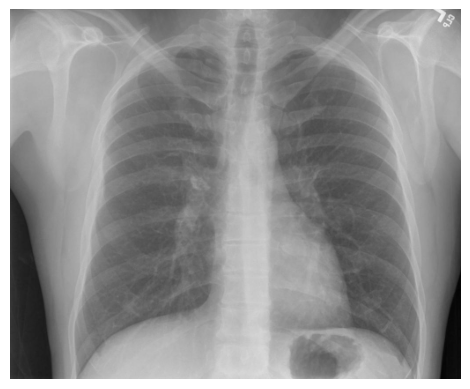

Generated report: Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.


In [27]:
report = trainer.robust_generate_radiology_report(
    image_input="/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1007_IM-0008-1001.png",
    max_tokens=100,
    temperature_range=(0.5, 1.5),
    deterministic=True,
    show_image=True
)
print("Generated report:", report)

In [28]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [29]:
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths = batch['image_path']  # Ensure this exists and is batch-aligned

        for i in range(len(image_paths)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # Load image from the image path
            image_path = image_paths[i]
            pil_img = Image.open(image_path).convert('RGB')

            # Generate report from the image
            gen_report = trainer.robust_generate_radiology_report(
                pil_img,
                deterministic=True
            )

            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)

            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)

            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


Evaluating dataset: 100%|██████████| 47/47 [1:13:03<00:00, 93.26s/it]

       BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L
0    0.496675  0.234657  0.164716  0.114388  0.252708  0.238095
1    0.070914  0.044321  0.027032  0.017571  0.126285  0.200000
2    0.125394  0.040471  0.013491  0.007510  0.134399  0.190476
3    0.319506  0.196642  0.108944  0.044804  0.213285  0.217391
4    0.163013  0.079924  0.021140  0.010554  0.127202  0.151515
..        ...       ...       ...       ...       ...       ...
738  0.280000  0.108012  0.038258  0.021913  0.256466  0.171429
739  0.214171  0.114154  0.066414  0.027949  0.206985  0.222222
740  0.840000  0.815475  0.791059  0.760857  0.980885  0.944444
741  0.127477  0.049175  0.013761  0.007054  0.152697  0.194444
742  0.334885  0.197333  0.107722  0.043994  0.257637  0.217391

[743 rows x 6 columns]
Average Scores: {'BLEU-1': 0.2860172181155847, 'BLEU-2': 0.16028253618395621, 'BLEU-3': 0.10320215305223567, 'BLEU-4': 0.07537655999986513, 'METEOR': 0.2544826668682366, 'ROUGE-L': 0.2717100859203364}


In [30]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([test_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [31]:
results_df, avg_scores = evaluate_dataloader_metrics_v2(combined_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)

Evaluating dataset: 100%|██████████| 47/47 [1:12:49<00:00, 92.98s/it]

       BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L
0    0.228484  0.073743  0.024583  0.013684  0.169016  0.150943
1    0.334885  0.139535  0.040083  0.020803  0.257637  0.250000
2    0.440000  0.234521  0.136442  0.057419  0.525698  0.312500
3    0.066826  0.033084  0.017022  0.006761  0.151283  0.181818
4    0.116821  0.015392  0.008278  0.005771  0.084951  0.071429
..        ...       ...       ...       ...       ...       ...
738  0.134064  0.061192  0.022950  0.013504  0.125408  0.125000
739  0.566372  0.451883  0.368461  0.305758  0.555099  0.577778
740  0.184623  0.026648  0.014783  0.010457  0.093284  0.046512
741  0.024212  0.008185  0.002188  0.001088  0.067114  0.108434
742  0.241315  0.082097  0.027863  0.015641  0.171750  0.170213

[743 rows x 6 columns]
Average Scores: {'BLEU-1': 0.28499235350999397, 'BLEU-2': 0.1603582991442002, 'BLEU-3': 0.10147949167029433, 'BLEU-4': 0.07351930300528466, 'METEOR': 0.25465605634924143, 'ROUGE-L': 0.26880112634912573}


In [32]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images = sample_batch['image']
    input_ids = sample_batch['input_ids']

    total_samples = min(num_samples, images.size(0))
    selected_indices = random.sample(range(images.size(0)), total_samples)

    for idx in selected_indices:
        # Get image tensor and decode ground truth report
        image_tensor = images[idx]
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Reverse normalization for visualization
        image_disp = (image_tensor * std) + mean
        image_disp = transforms.ToPILImage()(image_disp)

        # Save image temporarily
        temp_path = "temp_image.png"
        image_disp.save(temp_path)

        # Generate report using your trainer
        generated_report = trainer.robust_generate_radiology_report(
            image_input=temp_path,
            max_tokens=100,
            temperature_range=(0.5, 1.5),
            deterministic=True,
            show_image=False  # We'll handle visualization here
        )

        # Plot image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_disp)
        plt.axis('off')
        plt.title("Validation Sample Image")
        plt.show()

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)

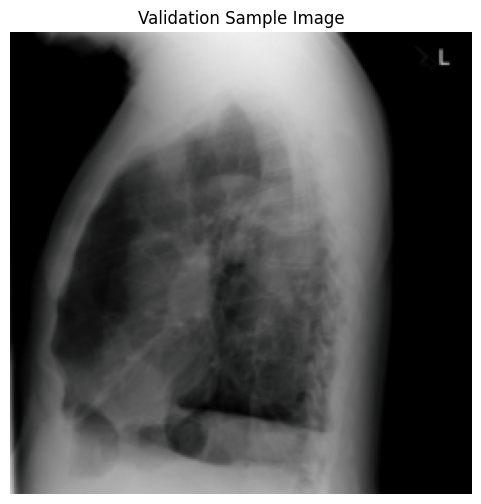


--- Ground Truth Report ---
the lungs are hyperexpanded. there are stable scattered bilateral opacities, most notable in the left upper lobe, scarring. no focal airspace consolidation to suggest pneumonia. no large pleural effusion. no pneumothorax. heart size is normal. thoracic aorta is mildly tortuous and demonstrates atherosclerotic vascular calcification. there are degenerative changes of the spine.  1. no acute findings. 2. emphysema. 3. scattered of scarring, most notably in the left upper lobe.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is stable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


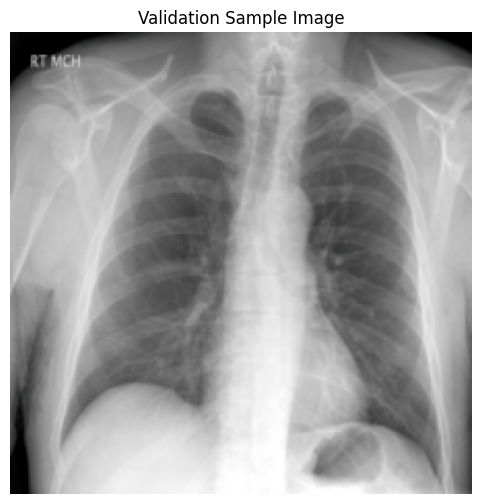


--- Ground Truth Report ---
the cardiac silhouette and mediastinal contours are within normal limits. there is no focal opacity. there is no pneumothorax. there is no large pleural effusion.  no acute cardiopulmonary disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


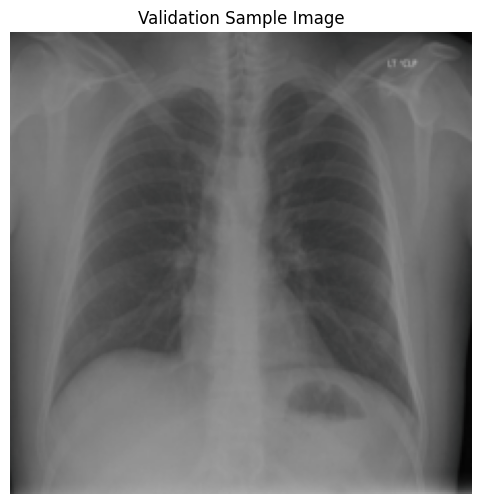


--- Ground Truth Report ---
the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. no acute osseus abnormality.  no acute cardiopulmonary process.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


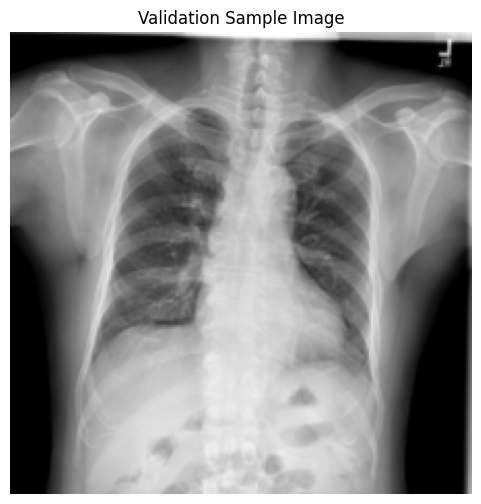


--- Ground Truth Report ---
heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. vascular calcification is noted.  1. no evidence of active disease.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


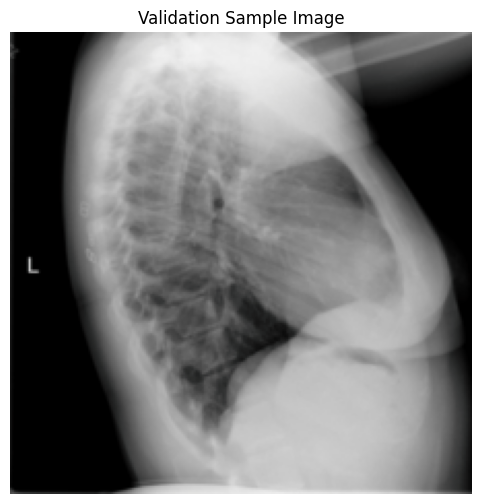


--- Ground Truth Report ---
cardiomediastinal silhouette and central pulmonary vasculature are within normal limits. there is no focal air space opacity. no pleural effusion or pneumothorax is seen. no acute bony abnormality is demonstrated.  no acute cardiopulmonary abnormality.

--- Generated Report ---
Findings: the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.
Impression: no acute disease.
--------------------------------------------------------------------------------


In [33]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)